# Event Statistics

This notebook plots basic event statistics for the datasets obtained through the detection pipeline. 

In [12]:
# setup
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import linregress
import pickle
import glob
import sunpy.map
from sunpy.visualization.colormaps import cm
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

In [3]:
# set up paths
csv_dir = Path("../results/csv")
dataset = "20200530"

event_df = pd.read_csv(csv_dir / "detections_test8.csv")

Time for some plots.

C:\Users\David\AppData\Local\Temp\ipykernel_11224\466315629.py:40: RuntimeWarning: invalid value encountered in log10
  lambda xx, A, B: np.log10(power_law(xx, A, B)),


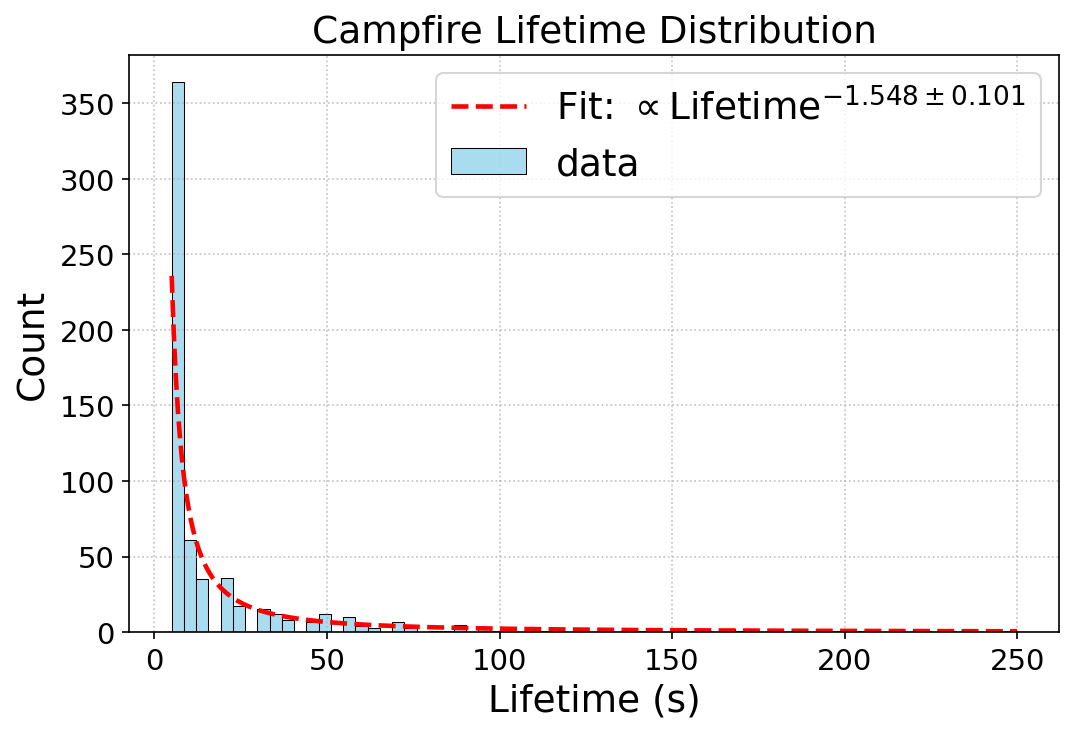

In [ ]:
# Campfire Lifetime distribution plot
# Data
x_data = event_df["total_lifetime_seconds"].values
x_data = x_data[x_data > 0]  # remove non-positive values
x_data = x_data[x_data < 1000000] # remove too big values

# Linear-scale histogram (equal-width bins)
fig, ax = plt.subplots(figsize=(8, 5), dpi = 150)

# calculate bin number with Freedman-Diaconis rule
n = len(x_data)
iqr = np.percentile(x_data, 75) - np.percentile(x_data, 25)

n_bins = int((x_data.max() - x_data.min()) / (2 * iqr * n**(-1/3)))
linear_bins = np.linspace(x_data.min(), x_data.max(), n_bins + 1)

sns.histplot(
    x_data,
    ax=ax,
    bins=linear_bins,
    stat="count",
    color="skyblue",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    label="data"
)

# Power-law model
def power_law(x, a, b):
    return a * x**b

# Fit in log-log space + extract uncertainties
counts, _ = np.histogram(x_data, bins=linear_bins)
bin_centers = 0.5 * (linear_bins[:-1] + linear_bins[1:])
mask = counts > 0

# Fit in log-log space
popt, pcov = curve_fit(
    lambda xx, A, B: np.log10(power_law(xx, A, B)),
    bin_centers[mask],
    np.log10(counts[mask]),
    p0=(1e4, -1.0)
)

A_fit, B_fit = popt
perr = np.sqrt(np.diag(pcov))       # standard errors
A_err, B_err = perr

# Smooth curve for plotting
x_fit = np.linspace(x_data.min(), x_data.max(), 400) 
y_fit = power_law(x_fit, A_fit, B_fit)

ax.plot(
    x_fit, y_fit,
    color="red", linewidth=2.2, linestyle="--",
    label=rf"Fit: $\propto \mathrm{{Lifetime}}^{{{B_fit:.3f} \pm {B_err:.3f}}}$"
)

# Final formatting
#plt.yscale("log")
#plt.xscale("log")
ax.set_xlabel("Lifetime (s)", fontsize = 18)
ax.set_ylabel("Count", fontsize = 18)
ax.set_title("Campfire Lifetime Distribution", fontsize = 18)
ax.legend(fontsize = 18)
ax.grid(True, ls=":", alpha=0.8)
ax.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Plotting 621 events

Power-law fit:
Peak Intensity ~ (Mean Area)^0.009
beta = 0.009)
R^2= 0.4378


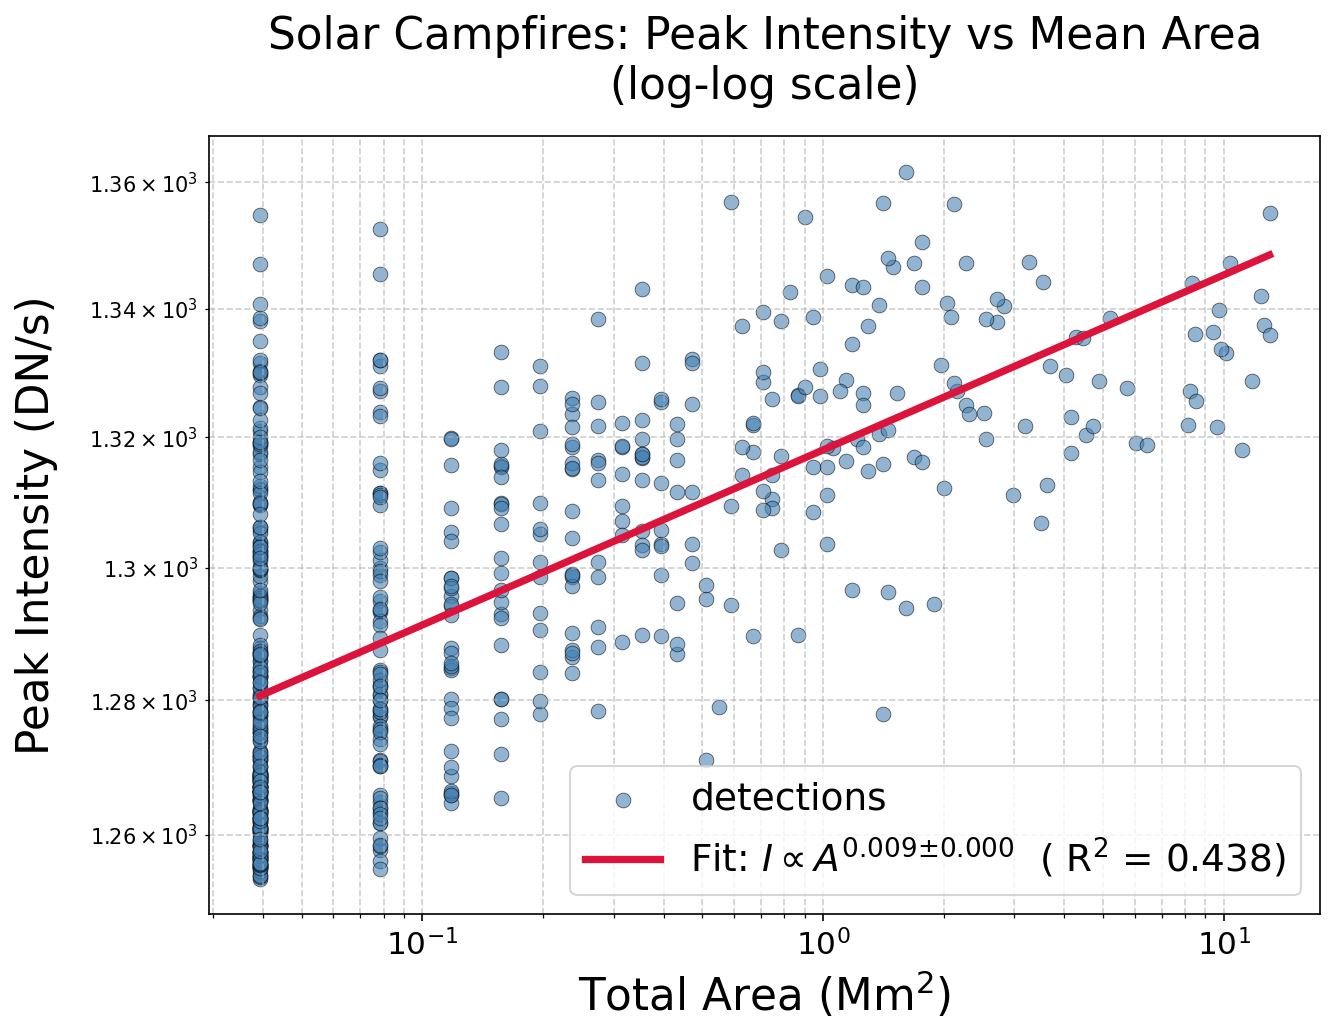

In [17]:
# Peak Intensity vs Area Plot
# 1. Prepare and filter data (only positive values for log)
df = event_df.copy()

# Remove non-positive values
df = df[df["total_area_Mm2"] > 0]
df = df[df["peak_intensity"] > 0]

# Optional: physical cuts (adjust as needed)
#df = df[df["mean_area_km2"] <= 5e7]        # remove extreme outliers
df = df[df["peak_intensity"] <= 1.9e3]

filtered_df = df

print(f"Plotting {len(filtered_df)} events")

# 2. Log-log scatterplot
plt.figure(figsize=(9, 7), dpi = 150)

sns.scatterplot(
    data=filtered_df,
    x="total_area_Mm2",
    y="peak_intensity",
    color="steelblue",
    alpha=0.6,
    edgecolor="k",
    linewidth=0.4,
    s=50,
    label=f"detections"
)

# 3. Fit power law: Intensity ~ Area^beta
log_x = np.log10(filtered_df["total_area_Mm2"])
log_y = np.log10(filtered_df["peak_intensity"])

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

beta = slope
beta_err = std_err

r2 = r_value**2

print(f"\nPower-law fit:")
print(f"Peak Intensity ~ (Mean Area)^{beta:.3f}")
print(f"beta = {beta:.3f})")
print(f"R^2= {r2:.4f}")

# Plot the fit line
x_fit = np.logspace(
    np.log10(filtered_df["total_area_Mm2"].min()),
    np.log10(filtered_df["total_area_Mm2"].max()),
    200
)
y_fit = 10**(intercept + slope * np.log10(x_fit))

plt.loglog(x_fit, y_fit, color="crimson", linewidth=3.5,
           label=rf"Fit: $I \propto A^{{{beta:.3f} ± {beta_err:.3f}}}$" + rf"  ( R$^2$ = {r2:.3f})")

# 4. Log-log axes and polish
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Total Area (Mm$^2$)", fontsize=21)
plt.ylabel("Peak Intensity (DN/s)", fontsize=21, labelpad = 15)
plt.title("Solar Campfires: Peak Intensity vs Mean Area\n(log-log scale)", fontsize=21, pad=18)
plt.tick_params("x", labelsize = 15)
plt.tick_params("y", labelsize = 15)

plt.grid(True, which="both", ls="--", alpha=0.6, lw=0.8)


plt.legend(fontsize=18, loc="lower right")
plt.tight_layout()
plt.show()

R$^2$ = 0.700, p-value = 2.317e-164


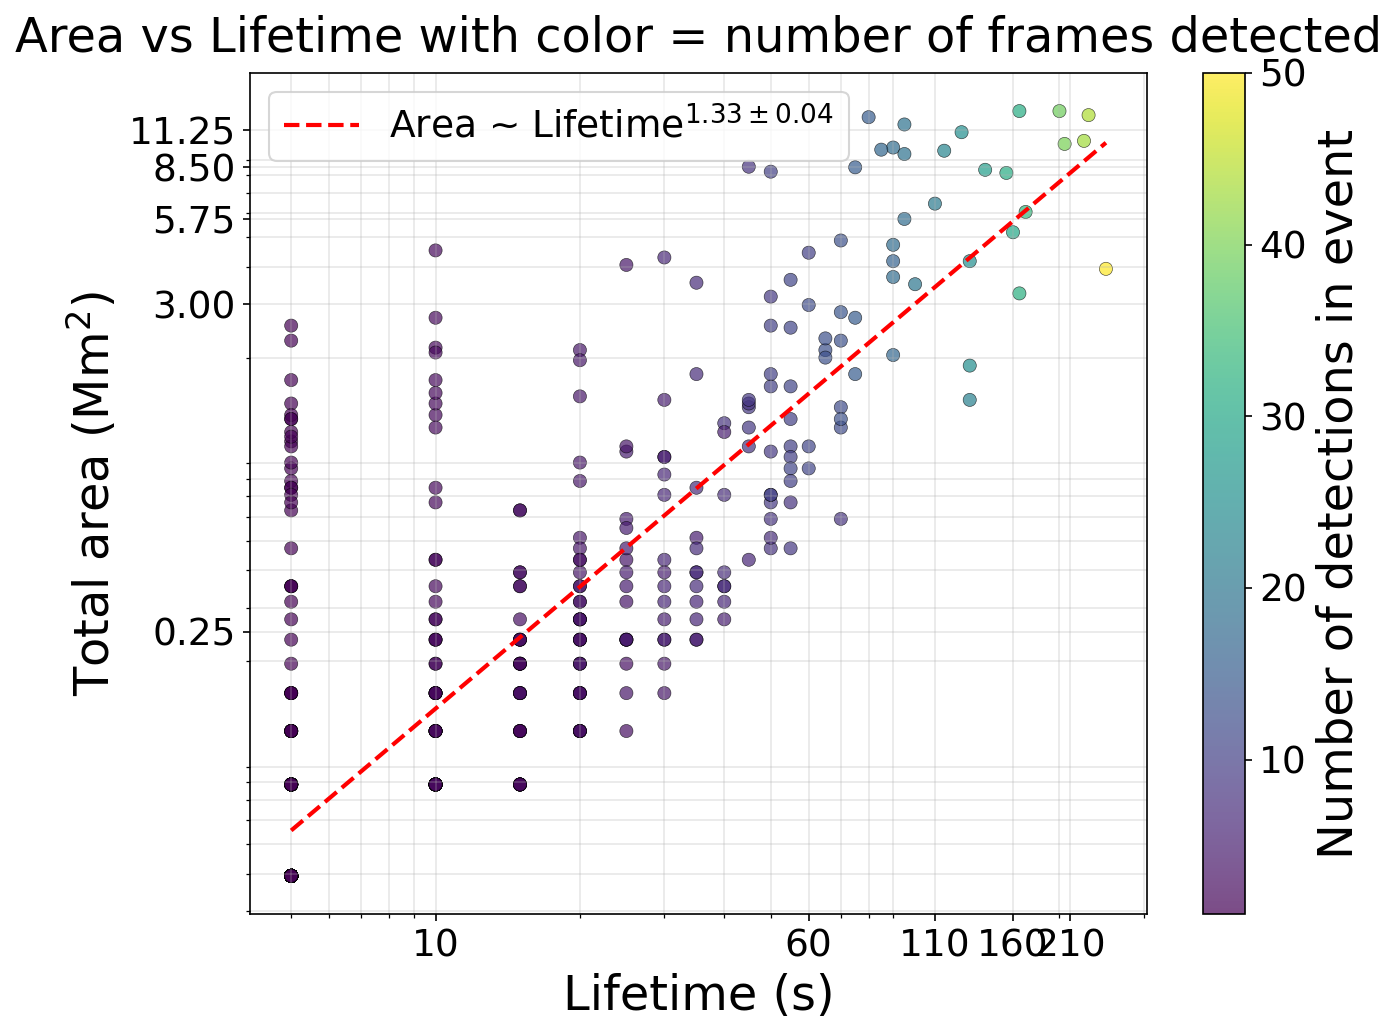

In [ ]:
# Area vs Lifetime + Colormap + Fit
# Perform log-log linear regression for power-law fit: log(y) = α log(x) + β
logx = np.log10(event_df["total_lifetime_seconds"])
logy = np.log10(event_df["total_area_Mm2"])

# Filter out non-finite values to avoid fit issues
mask = np.isfinite(logx) & np.isfinite(logy)
logx_clean = logx[mask]
logy_clean = logy[mask]

result = linregress(logx_clean, logy_clean)
alpha = result.slope
alpha_err = result.stderr

# Check if the fit is meaningful
print(rf"R$^2$ = {result.rvalue**2:.3f}, p-value = {result.pvalue:.3e}")

plt.figure(figsize=(9,7), dpi = 150)
sc = plt.scatter(event_df["total_lifetime_seconds"],
                 event_df["total_area_Mm2"],
                 c=event_df["n_detections"],
                 cmap="viridis", alpha=0.7, s=40, edgecolors="k", linewidth=0.3)
cb = plt.colorbar(sc)
cb.set_label(label="Number of detections in event", fontsize = 23)
cb.ax.tick_params(labelsize = 18)

# Set log scales
plt.xscale("log")
plt.yscale("log")

# Custom x-axis ticks
ax = plt.gca()
x_ticks = np.arange(10, event_df["total_lifetime_seconds"].max() + 10, 50)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{int(x)}" for x in x_ticks])

# Custom y-axis ticks
y_ticks = np.arange(0.25, event_df["total_area_Mm2"].max() + 0.25, 2.75)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.2f}" for y in y_ticks])
ax.tick_params("both", labelsize = 18)

# Add the power-law fit line
x_min, x_max = event_df["total_lifetime_seconds"].min(), event_df["total_lifetime_seconds"].max()
x_fit = np.logspace(np.log10(x_min), np.log10(x_max), 100)
logx_fit = np.log10(x_fit)
y_fit = 10 ** (alpha * logx_fit + result.intercept)
plt.plot(x_fit, y_fit, "r--", linewidth=2, label=rf"Area ~ Lifetime$^{{{alpha:.2f} \pm {alpha_err:.2f}}}$")

plt.xlabel("Lifetime (s)", fontsize=23)
plt.ylabel(rf"Total area (Mm$^2$)", fontsize = 23)
plt.title(rf"Area vs Lifetime with color = number of frames detected", fontsize = 23, pad = 10)
plt.grid(alpha=0.3, which="both")
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

Cached sequence loaded (50 maps)


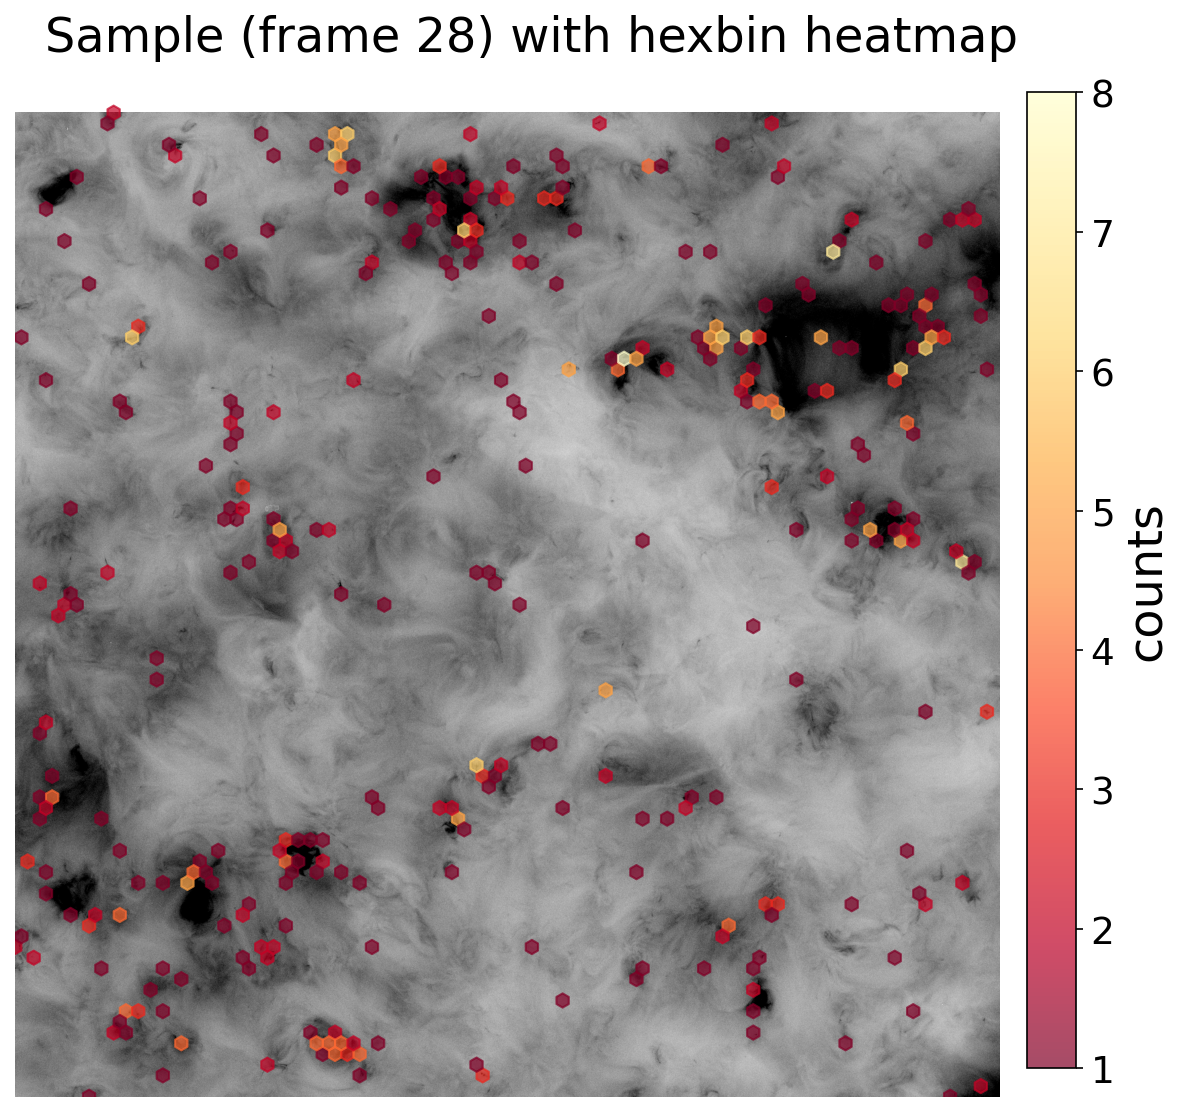

In [34]:
# Hexbin heatmap
# Settings
sample_frame = 28 # sample frame
hex_gridsize = 80 # try 40-100 depending on image size and desired smoothing
hex_mincnt = 1 # min counts per hex bin to show
hex_alpha = 0.7     
cmap_hex = plt.cm.YlOrRd_r # color map for hexbin; any that contrasts with greyscale is fine

# set up paths
raw_dir = Path(f"../data/raw/{dataset}")
processed_dir = Path("../data/processed")
cache_file = processed_dir / f"{dataset}_sequence.pkl"
processed_dir.mkdir(parents=True, exist_ok=True)

# load or render sequence if necessary
if cache_file.exists():
    sequence = pickle.load(open(cache_file, "rb"))
    print(f"Cached sequence loaded ({len(sequence)} maps)")
else:
    files = sorted(glob.glob(str(raw_dir / "*.fits")))
    sequence = sunpy.map.Map(files, sequence=True)
    pickle.dump(sequence, open(cache_file, "wb"))
    print(f"First load → saved cache ({len(sequence)} maps)")

# base image data (use float)
m = sequence[sample_frame]
data = m.data.astype(float)

# plot in grayscale (black & white)
plt.figure(figsize=(8,8), dpi = 150)
ax = plt.gca()

# display grayscale image with percentile stretch for good contrast
vmin, vmax = np.percentile(data, (0, 99))
ax.imshow(data, cmap="binary" , origin="lower", vmin=vmin, vmax=vmax)

# Build x,y lists for hexbin
x = event_df["x_centroid"].values
y = event_df["y_centroid"].values

hb = ax.hexbin(x, y, gridsize=hex_gridsize, cmap = cmap_hex, mincnt=hex_mincnt,
               extent=(0, data.shape[1], 0, data.shape[0]), alpha=hex_alpha)

# Add colorbar for hex counts
cb = plt.colorbar(hb, ax=ax, fraction=0.046, pad = -0.02)
cb.set_label("counts", fontsize = 23)
cb.ax.tick_params(labelsize = 18)

# set integer tick labels
cb.ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax.set_title(f"Sample (frame {sample_frame}) with hexbin heatmap", fontsize = 23)
ax.set_axis_off()
plt.tight_layout()
plt.show()

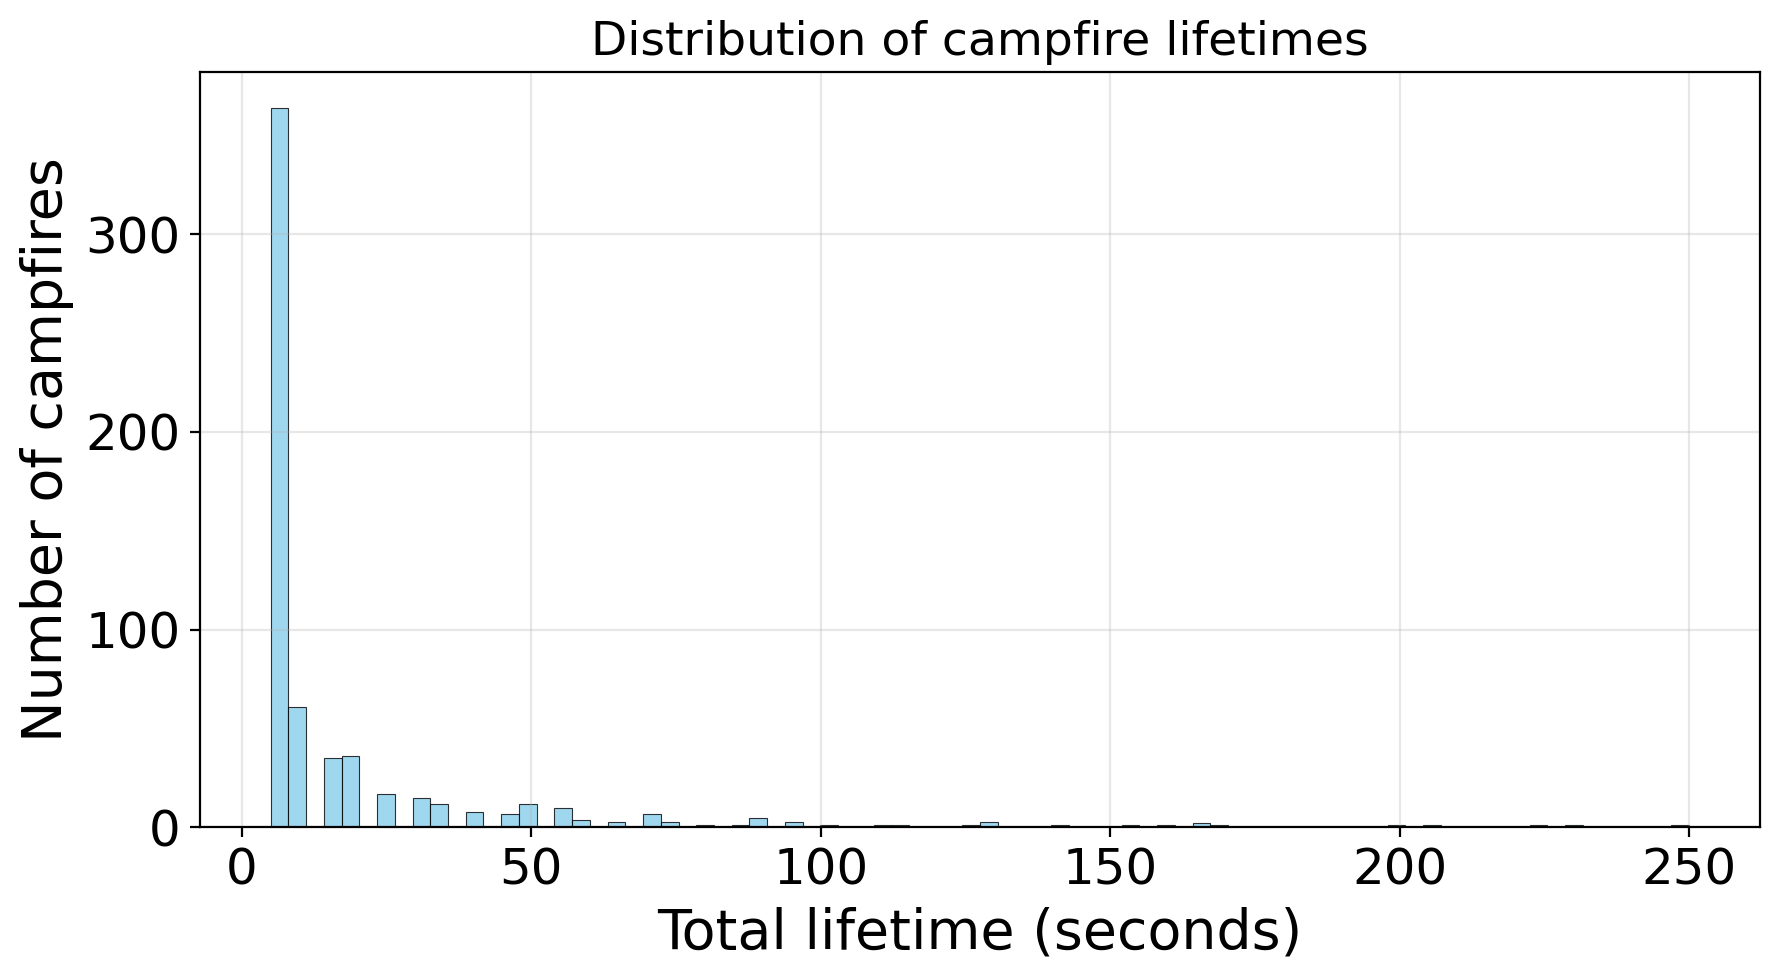

In [29]:
# Histogram: Lifetime distribution (no fit)

plt.figure(figsize=(9,5), dpi = 200)
plt.hist(event_df["total_lifetime_seconds"], bins=80, color="skyblue", alpha=0.8, edgecolor="k", linewidth=0.4)
plt.xlabel("Total lifetime (seconds)", fontsize = 20)
plt.ylabel("Number of campfires", fontsize = 20)
plt.title("Distribution of campfire lifetimes", fontsize = 17)
plt.tick_params("both", labelsize = 18)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

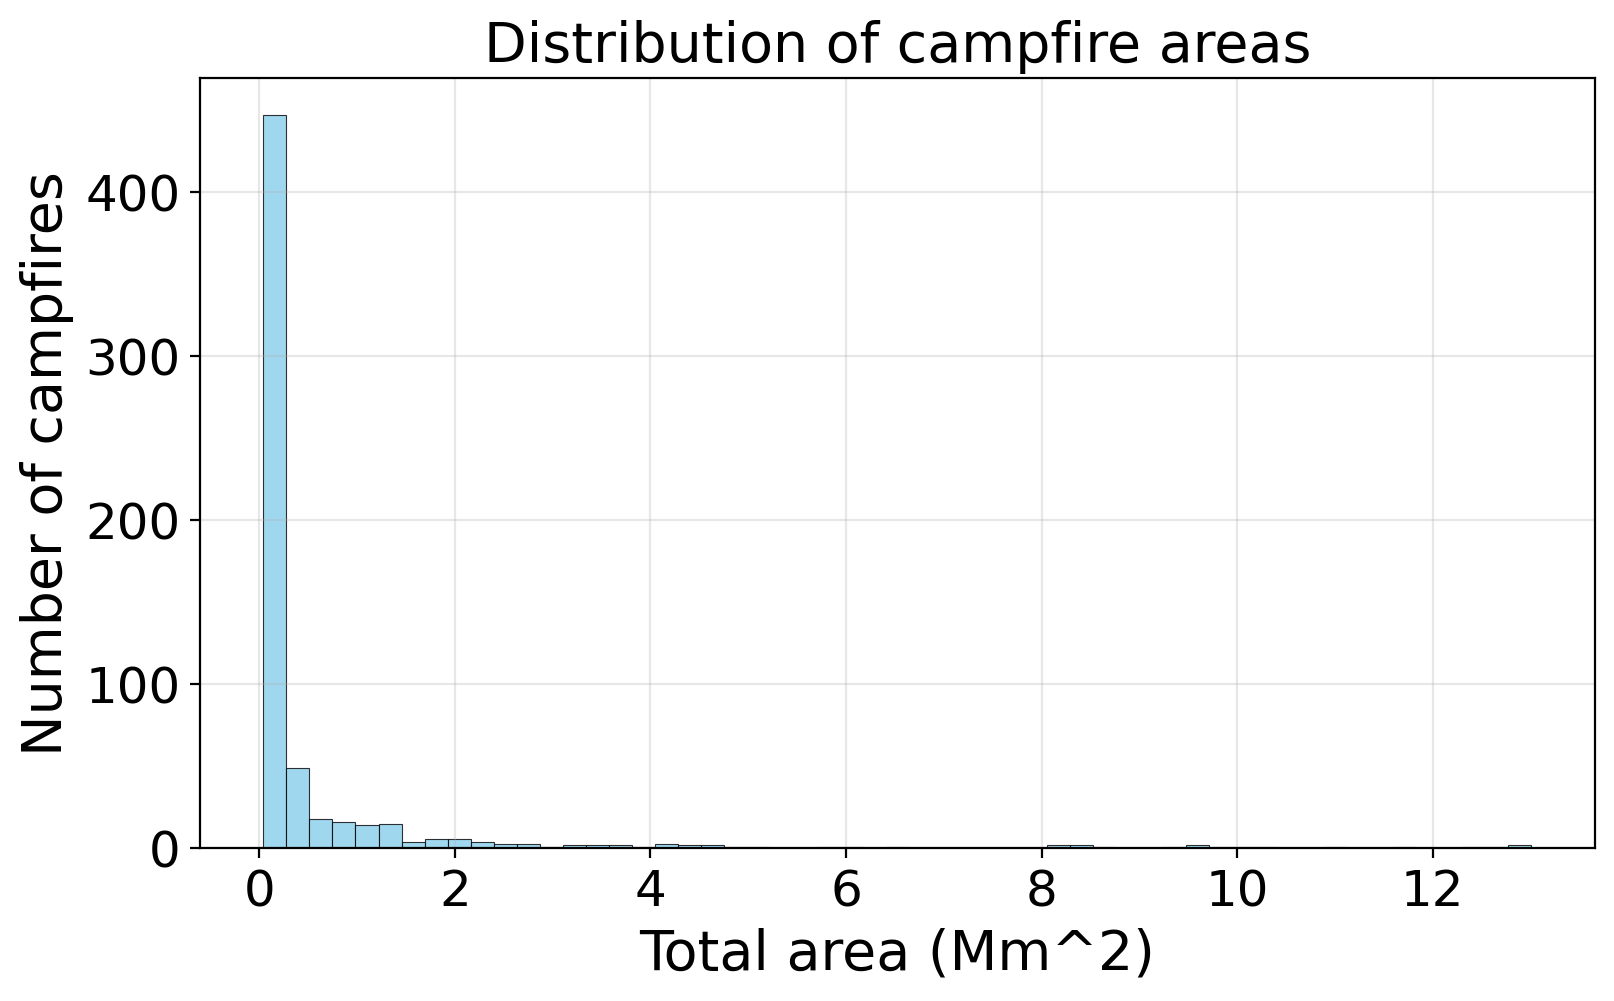

In [30]:
# Histogram: Area distribution (no fit)

plt.figure(figsize=(9,5), dpi = 200)
plt.hist(event_df["total_area_Mm2"], bins=55, color="skyblue", alpha=0.8, edgecolor="k", linewidth=0.4)
plt.xlabel("Total area (Mm^2)", fontsize = 20)
plt.ylabel("Number of campfires", fontsize = 20)
plt.title("Distribution of campfire areas", fontsize = 20)
plt.tick_params("both", labelsize = 18)
plt.grid(alpha=0.3)
plt.show()

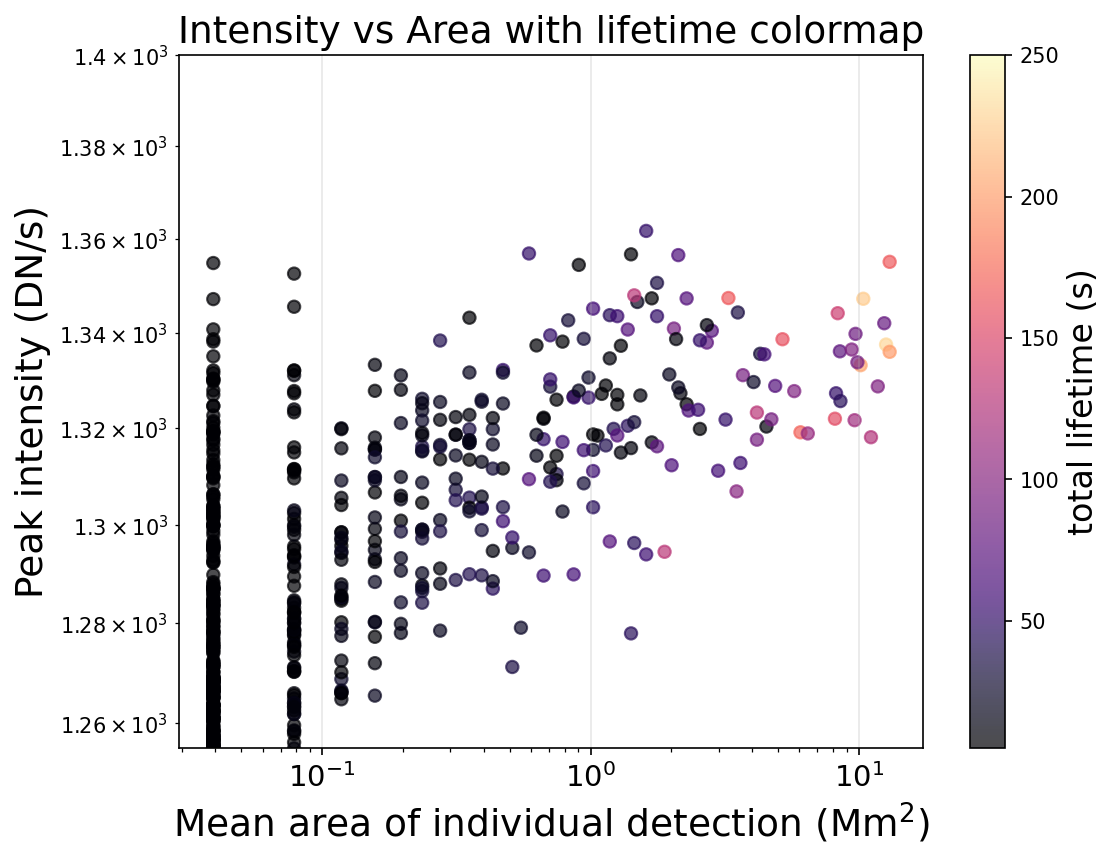

In [39]:
plt.figure(figsize=(8,6), dpi = 150)
plt.scatter(event_df["total_area_Mm2"], event_df["peak_intensity"],
            alpha=0.7, c=event_df["total_lifetime_seconds"], cmap="magma", s=35)
cb = plt.colorbar()
cb.set_label(label="total lifetime (s)", fontsize = 16)
plt.xscale("log"); plt.yscale("log")
plt.xlabel(rf"Mean area of individual detection (Mm$^2$)", fontsize = 18)
plt.ylabel("Peak intensity (DN/s)", fontsize = 18)
plt.title("Intensity vs Area with lifetime colormap", fontsize = 18)
plt.ylim(1.255e3, 1.4e3)
plt.tick_params("both", labelsize = 14)
plt.grid(alpha=0.3)
plt.show()